In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt 
import cv2
import numpy as np
import easyocr
import os

In [ ]:
img = cv2.imread('')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
model = YOLO('best.pt')
model.fuse()
result = model(source=img, conf=0.5)
# print(result)
for r in result:
    box = r.boxes.cpu().numpy()
xyxy = box.xyxy
print(xyxy)

Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

0: 416x640 1 plate, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


[[     260.95      251.87      342.29      272.71]]


In [ ]:
x, y, x_max, y_max = list(map(int, xyxy[0][:4]))

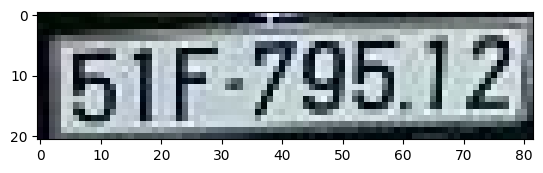

In [ ]:
plate = img[y:y_max, x:x_max].copy()
plt.imshow(plate)
plt.show()

In [ ]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:
plate_gray = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)
plate_blur = cv2.GaussianBlur(plate_gray, (5, 5), 0)
edges = cv2.Canny(plate_blur, 100, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
# test_img1 = plate.copy()
# cv2.drawContours(test_img1, max_contour, -1, (0, 255, 0), 10)
# plt.imshow(test_img1)
epsilon = 0.02*cv2.arcLength(max_contour, True)
approx = cv2.approxPolyDP(max_contour, epsilon, True)

if len(approx) == 4:
    width, height = 300, 100
    src = np.float32([list(approx[0][0]), list(approx[3][0]), list(approx[1][0]), list(approx[2][0])])
    # print(src)
    dst = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    # print(dst)

    M = cv2.getPerspectiveTransform(src, dst)

    test = plate_gray.copy()
    new_plate = cv2.warpPerspective(test, M, (width, height))
    # plt.imshow(new_plate, cmap='gray')
    # plt.show()
    _, thresholded_img = cv2.threshold(new_plate, 180, 255, cv2.THRESH_BINARY)
    # plt.imshow(thresholded_img, cmap='gray')
    # plt.show()
    dilation = cv2.dilate(thresholded_img, np.ones((4,4), np.uint8), iterations = 1)
    # plt.imshow(dilation, cmap='gray')
    # plt.show()
    
    number = reader.readtext(dilation)
    print(number)    
    print(number[0][1])
else:
    number = reader.readtext(plate)
    print(number)    
    print(number[0][1])

[([[0, 0], [82, 0], [82, 21], [0, 21]], '6IF.795.12', 0.3684892839442339)]
6IF.795.12
